## Project - Concrete Strength Prediction

In [1]:
# DON'T DO THIS
!pip3 install xlrd==1.2.0
!pip3 install openpyxl

### Importing necessary packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('concrete.csv')
print('Number of rows %d and number of columns %d' % data.shape)

Number of rows 1030 and number of columns 9


### Univariate Analysis

In [3]:
data.head(10)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
5,255.0,0.0,0.0,192.0,0.0,889.8,945.0,90,21.86
6,166.8,250.2,0.0,203.5,0.0,975.6,692.6,7,15.75
7,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,56,36.64
8,296.0,0.0,0.0,192.0,0.0,1085.0,765.0,28,21.65
9,155.0,184.0,143.0,194.0,9.0,880.0,699.0,28,28.99


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB
None


In [5]:
print(data.describe().transpose())

               count        mean         std     min      25%      50%  \
cement        1030.0  281.167864  104.506364  102.00  192.375  272.900   
slag          1030.0   73.895825   86.279342    0.00    0.000   22.000   
ash           1030.0   54.188350   63.997004    0.00    0.000    0.000   
water         1030.0  181.567282   21.354219  121.80  164.900  185.000   
superplastic  1030.0    6.204660    5.973841    0.00    0.000    6.400   
coarseagg     1030.0  972.918932   77.753954  801.00  932.000  968.000   
fineagg       1030.0  773.580485   80.175980  594.00  730.950  779.500   
age           1030.0   45.662136   63.169912    1.00    7.000   28.000   
strength      1030.0   35.817961   16.705742    2.33   23.710   34.445   

                   75%     max  
cement         350.000   540.0  
slag           142.950   359.4  
ash            118.300   200.1  
water          192.000   247.0  
superplastic    10.200    32.2  
coarseagg     1029.400  1145.0  
fineagg        824.000   992

### Duplicate Analysis

In [6]:
duplicate = data[data.duplicated()]
print("Number of duplicate records found %d" % duplicate.shape[0])

Number of duplicate records found 25


In [7]:
data = data.drop_duplicates()

### Number of unique in each column

In [8]:
print(data.nunique())

cement          278
slag            185
ash             156
water           195
superplastic    111
coarseagg       284
fineagg         302
age              14
strength        845
dtype: int64


### Number of nulls in each column

In [9]:
print(data.isnull().sum())

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64


### EDA

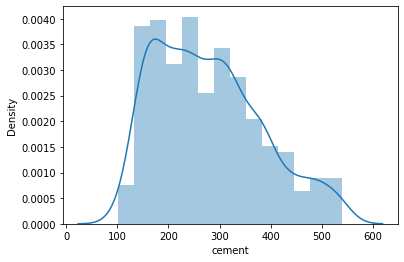

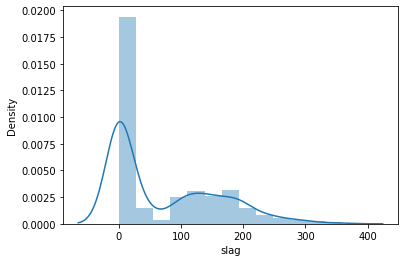

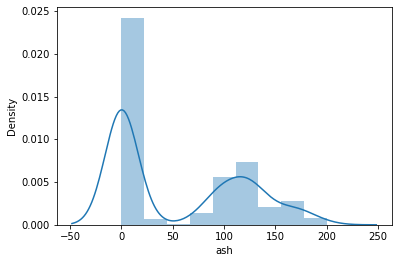

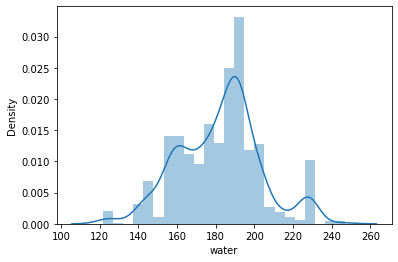

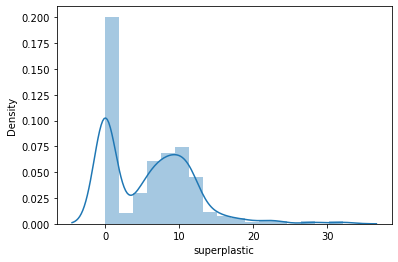

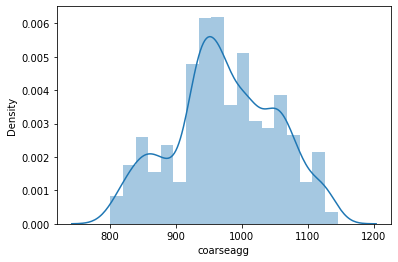

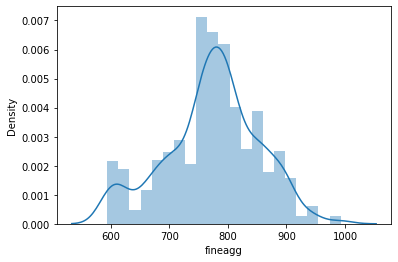

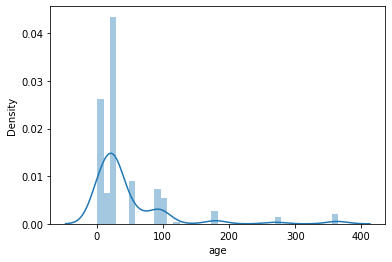

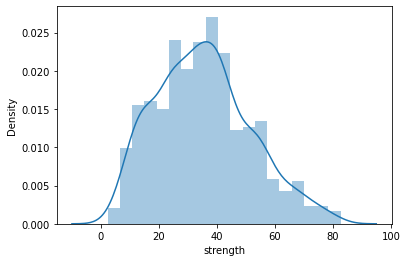

In [10]:
for i in data.columns:
    sns.distplot(data[i])
    plt.show()

### Outlier analysis

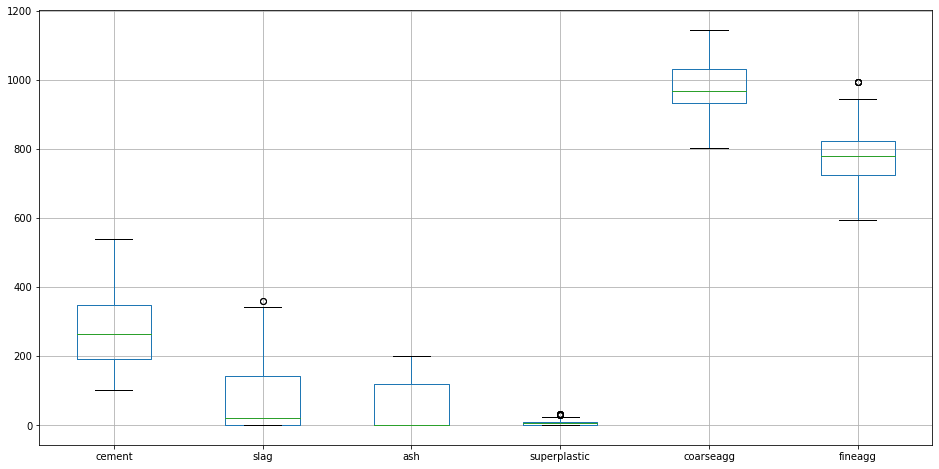

In [11]:
plt.subplots(figsize=(16,8))
boxplot = data.boxplot(column=['cement', 'slag', 'ash', 'superplastic', 'coarseagg', 'fineagg'])

In [12]:
Q1=data.quantile(0.25)
Q3=data.quantile(0.75)
IQR=Q3-Q1
cwo=((data.iloc[:] <(Q1-1.5*IQR))|(data.iloc[:]>(Q3+1.5*IQR))).sum(axis=0)
opdf=pd.DataFrame(cwo,index=data.columns,columns=['No. of Outliers'])
opdf['Outliers']=round(opdf['No. of Outliers']*100/len(data),2)
opdf.head(20)

,No. of Outliers,Outliers
cement,0,0.00
slag,2,0.20
ash,0,0.00
water,15,1.49
superplastic,10,1.00
coarseagg,0,0.00
fineagg,5,0.50
age,59,5.87
strength,8,0.80


### Using MICE to handle outliers in the dataset

In [13]:
imp = IterativeImputer()
imp.fit(data)
data=pd.DataFrame(imp.transform(data),columns=data.columns)


### Bivariate Analysis

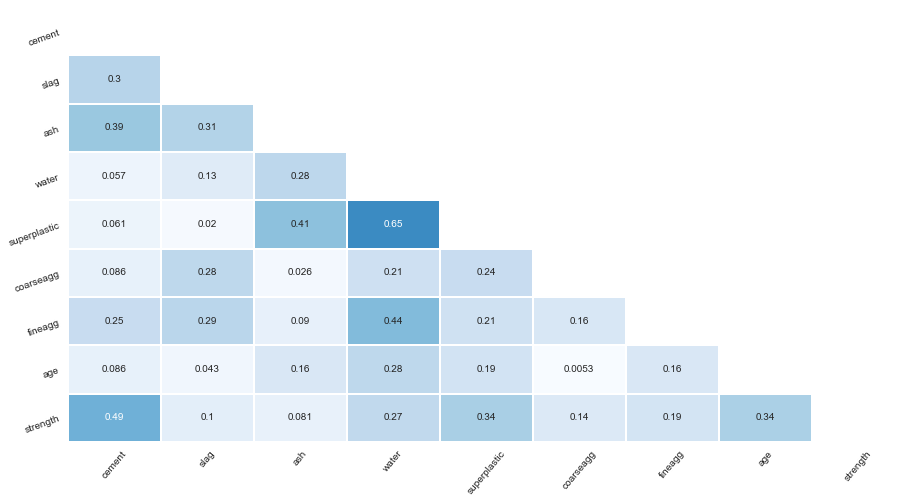

In [14]:
corr = abs(data.corr())
lower_triangle = np.tril(corr, k = -1)
mask = lower_triangle == 0

plt.figure(figsize = (15,8))
sns.set_style(style = 'white')  
sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', annot= True,
            xticklabels = corr.index, yticklabels = corr.columns, cbar= False, linewidths= 1, mask = mask)
plt.xticks(rotation = 50)   
plt.yticks(rotation = 20)
plt.show()


In [15]:
X = data.iloc[:,:8]
Y = data.iloc[:,8]

In [16]:
# ls=sm.OLS(Y,sm.add_constant(X))
# results=ls.fit()
# results.summary()

In [17]:
# ls=sm.OLS(Y,X)
# results=ls.fit()
# results.summary()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=150)

In [19]:
print("{0:0.2f}% data is in training set".format((len(X_train)/len(data.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(data.index)) * 100))

69.95% data is in training set
30.05% data is in test set


### Linear regression model

In [20]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

y_pred_lrtr=regression_model.predict(X_train)
y_pred_lrte=regression_model.predict(X_test)


print('Model score is %.2f' % regression_model.score(X_train, y_train))
print('Train R2 score: %.2f' % r2_score(y_train,y_pred_lrtr))
print('Test R2 score:  %.2f' % r2_score(y_test,y_pred_lrte))

Model score is 0.63
Train R2 score: 0.63
Test R2 score:  0.53


### Polynomial Feature analysis

In [21]:
pf = PolynomialFeatures(degree = 2)
X_polytr = pf.fit_transform(X_train)
regression_model.fit(X_polytr,y_train)
y_pred_lr2tr = regression_model.predict(X_polytr)
print("Training R2 - degree 2 polynomial: %.2f" % r2_score(y_train, y_pred_lr2tr ))

X_polyte = pf.fit_transform(X_test)
y_pred_lr2te = regression_model.predict(X_polyte)
print("Testing R2 - degree 2 polynomial: %.2f" % r2_score(y_test, y_pred_lr2te ))

Training R2 - degree 2 polynomial: 0.81
Testing R2 - degree 2 polynomial: 0.76


In [22]:
pf = PolynomialFeatures(degree = 3)
X_polytr = pf.fit_transform(X_train)
regression_model.fit(X_polytr,y_train)
y_pred_lr2tr = regression_model.predict(X_polytr)
print("Training R2 - degree 3 polynomial: %.2f" % r2_score(y_train, y_pred_lr2tr ))

X_polyte = pf.fit_transform(X_test)
y_pred_lr2te = regression_model.predict(X_polyte)
print("Testing R2 - degree 3 polynomial: %.2f" % r2_score(y_test, y_pred_lr2te ))

Training R2 - degree 3 polynomial: 0.93
Testing R2 - degree 3 polynomial: 0.75


In [23]:
pf = PolynomialFeatures(degree = 4)
X_polytr = pf.fit_transform(X_train)
regression_model.fit(X_polytr,y_train)
y_pred_lr2tr = regression_model.predict(X_polytr)
print("Training R2 - degree 4 polynomial: %.2f" % r2_score(y_train, y_pred_lr2tr ))

X_polyte = pf.fit_transform(X_test)
y_pred_lr2te = regression_model.predict(X_polyte)
print("Testing R2 - degree 4 polynomial: %.2f" % r2_score(y_test, y_pred_lr2te ))

Training R2 - degree 4 polynomial: 0.98
Testing R2 - degree 4 polynomial: -639.52


- Model performance degrades beyond this point. This shows that model is non-linear.


### Decision Trees

In [24]:
model_performance = {'Model': [],'Accuracy': [],'Standard_Div': []}

In [25]:
dt=DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred_dttr=dt.predict(X_train)
y_pred_dtte=dt.predict(X_test)

print('Train R2 score: %.2f' % r2_score(y_train,y_pred_dttr))
print('Test R2 score: %.2f'% r2_score(y_test,y_pred_dtte))

Train R2 score: 1.00
Test R2 score: 0.82


 - Model is over-fitting the data.

In [26]:
num_folds = 10
kfold = KFold(n_splits=num_folds)

accuracy = cross_val_score(dt, X, Y, scoring='r2', cv = kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (accuracy.mean()*100.0, accuracy.std()*100.0))

model_performance['Model'].append('DecisionTreeRegressor')
model_performance['Standard_Div'].append('%.2f' % (accuracy.std()*100.0))
model_performance['Accuracy'].append('%.2f' % (accuracy.mean()*100.0))

Accuracy: 84.85% (4.10%)


In [27]:
abr = AdaBoostRegressor(random_state=0, n_estimators=100)

accuracy = cross_val_score(abr, X, Y, scoring='r2', cv = kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (accuracy.mean()*100.0, accuracy.std()*100.0))

model_performance['Model'].append('AdaBoostRegressor')
model_performance['Standard_Div'].append('%.2f' % (accuracy.std()*100.0))
model_performance['Accuracy'].append('%.2f' % (accuracy.mean()*100.0))

Accuracy: 77.39% (3.82%)


In [28]:
rfr=RandomForestRegressor()

accuracy = cross_val_score(rfr, X, Y, scoring='r2', cv = kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (accuracy.mean()*100.0, accuracy.std()*100.0))

model_performance['Model'].append('RandomForestRegressor')
model_performance['Standard_Div'].append('%.2f' % (accuracy.std()*100.0))
model_performance['Accuracy'].append('%.2f' % (accuracy.mean()*100.0))

Accuracy: 91.15% (3.06%)


In [29]:
gb=GradientBoostingRegressor()

accuracy = cross_val_score(gb, X, Y, scoring='r2', cv = kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (accuracy.mean()*100.0, accuracy.std()*100.0))

model_performance['Model'].append('GradientBoostingRegressor')
model_performance['Standard_Div'].append('%.2f' % (accuracy.std()*100.0))
model_performance['Accuracy'].append('%.2f' % (accuracy.mean()*100.0))

Accuracy: 89.82% (2.11%)


In [30]:
bgcl = BaggingRegressor(base_estimator=dt, n_estimators=50,random_state=1)

accuracy = cross_val_score(bgcl, X, Y, scoring='r2', cv = kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (accuracy.mean()*100.0, accuracy.std()*100.0))

model_performance['Model'].append('BaggingRegressor')
model_performance['Standard_Div'].append('%.2f' % (accuracy.std()*100.0))
model_performance['Accuracy'].append('%.2f' % (accuracy.mean()*100.0))

Accuracy: 90.69% (2.98%)


### Performance Matrix

In [31]:
df = pd.DataFrame(model_performance, columns = ['Model', 'Accuracy', 'Standard_Div'])
df.head(20)

,Model,Accuracy,Standard_Div
0,DecisionTreeRegressor,84.85,4.10
1,AdaBoostRegressor,77.39,3.82
2,RandomForestRegressor,91.15,3.06
3,GradientBoostingRegressor,89.82,2.11
4,BaggingRegressor,90.69,2.98


### Hyper parameter tuning using GridSearchCV

In [32]:
model_performance = {'Model': [],'R2_Score': []}

In [33]:
# param_grid = {'max_depth': np.arange(3, 6),
#              'criterion' : ['mse','mae'],
#              'max_leaf_nodes': [100,105, 90,95],
#              'min_samples_split': [6,7,8,9,10],
#              'max_features':[2,3,4,5,6]}

# grid_tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = kfold, scoring= 'r2')
# grid_tree.fit(X_train, y_train)

# print(grid_tree.best_estimator_)
# print('Test R2 score: %.2f' % np.abs(grid_tree.best_score_))

# model_performance['Model'].append('DecisionTreeRegressor')
# model_performance['R2_Score'].append('%.2f' % np.abs(grid_tree.best_score_))

In [34]:
param_grid = {'n_estimators': [230],
              'max_depth': range(10,31,2), 
              'min_samples_split': range(50,501,10), 
              'learning_rate':[0.2]}

clf = GridSearchCV(GradientBoostingRegressor(random_state=1), param_grid = param_grid, scoring='r2', cv=kfold)
clf.fit(X_train, y_train)
print(clf.best_estimator_) 
print("R Squared: %.2f " % clf.best_score_)

model_performance['Model'].append('GradientBoostingRegressor')
model_performance['R2_Score'].append('%.2f' % clf.best_score_)

GradientBoostingRegressor(learning_rate=0.2, max_depth=10,
                          min_samples_split=170, n_estimators=230,
                          random_state=1)
R Squared: 0.92 


In [35]:
param_grid = {'max_depth': np.arange(3, 8),
             'criterion' : ['mse','mae'],
             'max_leaf_nodes': [100,105, 90,95],
             'min_samples_split': [6,7,8,9,10],
             'max_features':['auto','sqrt','log2']}

grid_tree = GridSearchCV(RandomForestRegressor(), param_grid, cv = kfold, scoring= 'r2')
grid_tree.fit(X_train, y_train)
print(grid_tree.best_estimator_)
print("R Squared: %.2f " % np.abs(grid_tree.best_score_))

model_performance['Model'].append('RandomForestRegressor')
model_performance['R2_Score'].append('%.2f' % np.abs(grid_tree.best_score_))

RandomForestRegressor(max_depth=7, max_leaf_nodes=105, min_samples_split=6)
R Squared: 0.84 


### Performance Matrix

In [36]:
df = pd.DataFrame(model_performance, columns = ['Model', 'R2_Score'])
df.head(20)

,Model,R2_Score
0,GradientBoostingRegressor,0.92
1,RandomForestRegressor,0.84


### Using GradientBoostingRegressor with hyper parameter tuning

In [38]:
gb = GradientBoostingRegressor(random_state=1, 
                               learning_rate=0.2, 
                               max_depth=10, 
                               min_samples_split=170, 
                               n_estimators=230)

gb.fit(X_train,y_train)
gb.score(X_train,y_train)
y_pred_rfrtr=gb.predict(X_train)
y_pred_rfrte=gb.predict(X_test)
print('Train R2 score: %.2f' % r2_score(y_train,y_pred_rfrtr))
print('Test R2 score: %.2f' % r2_score(y_test,y_pred_rfrte))

Train R2 score: 0.99
Test R2 score: 0.93


### Significance of the R2 score
- R-Squared is a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable
- R2 is a measure of the error
- Lower R2 values correspond to model with more error, which in turn produces predictions that are less precise.
- R-squared shows how well the data fit the regression model

### Inference
- The compressive strength increases with higher content of super plasticizers.
- When the blast furnace slag is greater than 50 kg/m3, the compressive strength increases.
- When there is no fly ash present, but the mix with highest content of superplasticizers have a positive impact on the compressive strength.
- Water content less than 150 kg/m3 with lower blast furnac slag provides the highest compressive strength
- Superplasticizers in the range of 10-12kg/m3 along with higher blast furnace slag increases the compressive strength.
- With increasing coarse aggregate, keeping the cement content lower, has positive impact on the compressive strength.
- There is inverse relation between fine aggregate and water content.
- There is direct relationship between age and compressive strength.